## We will attempt to use a long short-term memory model (LSTM) to predict changes in the currency exchange rate between GBP (British Pounds) and SGD (Singapore Dollar).

For a start, I will employ a [LSTM model](https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/) that looks at the changes in prices for the past 10 trading days (T-10) and attempt to predict the change in price for the next day (T+1).

Afterwards, I will explore the use of technical indicators such as [Relative Strength Index](https://www.wallstreetmojo.com/relative-strength-index/) (RSI) and 200-day [Simple Moving Average](https://www.investopedia.com/terms/s/sma.asp) (MA) to predict changes in price.

Lastly, I will experiment if using both these methods together would bring any reasonable prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm
from datetime import datetime as dt

In [2]:
# Contains GBP to SGD exchange rate data from 1 Dec 2003 to 30 Aug 2024. The price indicates how
# much SGD is equivalent to 1 GBP.
df = pd.read_csv('GBP_to_SGD.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,12/1/2003,2.9715,2.9741,2.9578,2.9589,2.9589,-
1,12/2/2003,2.9589,2.9785,2.9554,2.9737,2.9737,-
2,12/3/2003,2.9737,2.9782,2.9614,2.9646,2.9646,-
3,12/4/2003,2.9632,2.965,2.9453,2.9481,2.9481,-
4,12/5/2003,2.9483,2.9695,2.9475,2.9695,2.9695,-


### We will only be using the (adjusted) closing price each day so we can drop other columns.

In [4]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [5]:
df["Adj Close"] = df["Adj Close"].apply(pd.to_numeric, errors='coerce')

In [6]:
df.head()

,Date,Adj Close
0,12/1/2003,2.9589
1,12/2/2003,2.9737
2,12/3/2003,2.9646
3,12/4/2003,2.9481
4,12/5/2003,2.9695


In [7]:
# There are a few rare null data especially for data collected many years back
df.isnull().values.any()

True

In [8]:
# Use forward filling to fill any missing data
df["Adj Close"].ffill(inplace=True)

In [9]:
df.isnull().values.any()

False

#### Many LSTM models seem to have a high accuracy as they simply read the previous day's price and predict near it, resulting in a model that simply lags behind the actual price by a day. I would however try to analyse the **change** in price instead.

In [10]:
df["Prev 1-day Change"] = df["Adj Close"].diff(1)

In [11]:
df.iloc[200]

,200
Date,9/5/2004
Adj Close,3.0338
Prev 1-day Change,0.0105


In [12]:
# Calculate until we have the past 10 changes in price
for i in range(2, 11):
  df[f"Prev {i}-day Change"] = df["Prev 1-day Change"].shift(periods=i)

In [13]:
df.iloc[200]

,200
Date,9/5/2004
Adj Close,3.0338
Prev 1-day Change,0.0105
Prev 2-day Change,-0.0102
Prev 3-day Change,-0.0231
Prev 4-day Change,0.0068
Prev 5-day Change,0.0111
Prev 6-day Change,-0.0109
Prev 7-day Change,0.0035
Prev 8-day Change,0.0036


### We will calculate the 200-day simple moving average as well as the 14-day RSI (these will be used in the later part of the notebook).

In [14]:
df["MA"] = df["Adj Close"].rolling(window=200).mean()

In [15]:
# Since the actual prices are not our X data (rather the change in price), we will look at
# the difference to the moving average instead of the MA itself.
df["Difference to MA"] = df["Adj Close"] - df["MA"]

In [16]:
df.iloc[200]

,200
Date,9/5/2004
Adj Close,3.0338
Prev 1-day Change,0.0105
Prev 2-day Change,-0.0102
Prev 3-day Change,-0.0231
Prev 4-day Change,0.0068
Prev 5-day Change,0.0111
Prev 6-day Change,-0.0109
Prev 7-day Change,0.0035
Prev 8-day Change,0.0036


In [17]:
df["Percentage change"] = df["Adj Close"].pct_change()

In [18]:
# Calculating using the RSI formula
def RSI(srs):
  cnt_increase = 0
  cnt_decrease = 0
  increase = 0
  decrease = 0
  for e in srs:
    if e < 0 :
      cnt_decrease += 1
      decrease += abs(e)
    else:
      cnt_increase += 1
      increase += e

  if cnt_increase == 14:
    return 100

  elif cnt_decrease == 14:
    return 0

  else:
    rsi = 100 - (100 / (1 + (increase / 14) / (decrease / 14)))
    return rsi

In [19]:
df["RSI"] = df["Percentage change"].rolling(14).apply(RSI)

In [20]:
df.iloc[200]

,200
Date,9/5/2004
Adj Close,3.0338
Prev 1-day Change,0.0105
Prev 2-day Change,-0.0102
Prev 3-day Change,-0.0231
Prev 4-day Change,0.0068
Prev 5-day Change,0.0111
Prev 6-day Change,-0.0109
Prev 7-day Change,0.0035
Prev 8-day Change,0.0036



### We will now add the actual 1-Day change for each row (this is our Y values)

In [21]:
df["Actual 1-day Change"] = df["Prev 1-day Change"].shift(periods=-1)

In [22]:
df.iloc[197:202]

,Date,Adj Close,Prev 1-day Change,Prev 2-day Change,Prev 3-day Change,Prev 4-day Change,Prev 5-day Change,Prev 6-day Change,Prev 7-day Change,Prev 8-day Change,Prev 9-day Change,Prev 10-day Change,MA,Difference to MA,Percentage change,RSI,Actual 1-day Change
197,8/31/2004,3.0592,-0.0231,0.0111,-0.0109,0.0035,0.0036,-0.0239,-0.0213,-0.0178,0.0092,-0.0076,NaN,NaN,-0.007494,33.583929,-0.0102
198,9/1/2004,3.0490,-0.0102,0.0068,0.0111,-0.0109,0.0035,0.0036,-0.0239,-0.0213,-0.0178,0.0092,NaN,NaN,-0.003334,19.398689,-0.0257
199,9/2/2004,3.0233,-0.0257,-0.0231,0.0068,0.0111,-0.0109,0.0035,0.0036,-0.0239,-0.0213,-0.0178,3.092615,-0.069315,-0.008429,17.213982,0.0105
200,9/5/2004,3.0338,0.0105,-0.0102,-0.0231,0.0068,0.0111,-0.0109,0.0035,0.0036,-0.0239,-0.0213,3.092989,-0.059190,0.003473,24.255493,-0.0193
201,9/6/2004,3.0145,-0.0193,-0.0257,-0.0102,-0.0231,0.0068,0.0111,-0.0109,0.0035,0.0036,-0.0239,3.093193,-0.078693,-0.006362,22.764479,0.0173


In [23]:
# We do not need the Moving Average anymore
new_df = df.drop(['MA'], axis=1)

In [24]:
# We will drop the first 200 rows that do not have the "Difference to MA column" due to 200 days required for the
# first moving average to be calculated. We will also drop the last row as we cannot find its actual 1-day change.
new_df = df.drop([i for i in range(0, 200)])
new_df = new_df.drop([len(df)-1])

In [25]:
new_df.head()

,Date,Adj Close,Prev 1-day Change,Prev 2-day Change,Prev 3-day Change,Prev 4-day Change,Prev 5-day Change,Prev 6-day Change,Prev 7-day Change,Prev 8-day Change,Prev 9-day Change,Prev 10-day Change,MA,Difference to MA,Percentage change,RSI,Actual 1-day Change
200,9/5/2004,3.0338,0.0105,-0.0102,-0.0231,0.0068,0.0111,-0.0109,0.0035,0.0036,-0.0239,-0.0213,3.092989,-0.059190,0.003473,24.255493,-0.0193
201,9/6/2004,3.0145,-0.0193,-0.0257,-0.0102,-0.0231,0.0068,0.0111,-0.0109,0.0035,0.0036,-0.0239,3.093193,-0.078693,-0.006362,22.764479,0.0173
202,9/7/2004,3.0318,0.0173,0.0105,-0.0257,-0.0102,-0.0231,0.0068,0.0111,-0.0109,0.0035,0.0036,3.093530,-0.061730,0.005739,25.993870,0.0072
203,9/8/2004,3.0390,0.0072,-0.0193,0.0105,-0.0257,-0.0102,-0.0231,0.0068,0.0111,-0.0109,0.0035,3.093984,-0.054984,0.002375,31.091303,0.0138
204,9/9/2004,3.0528,0.0138,0.0173,-0.0193,0.0105,-0.0257,-0.0102,-0.0231,0.0068,0.0111,-0.0109,3.094400,-0.041600,0.004541,39.684535,-0.0037


#### Out of all these columns, for the LSTM model, the X-values are the T-1 to T-10 changes in price and the Y-value is the Actual 1-day change. As the LSTM reads data from right to left, the T-1 column should be all the way to the right, followed by T-2 etc.

In [26]:
cols = ["Date", "Adj Close", "Difference to MA", "RSI"]
for i in range(10, 0, -1):
  cols.append(f"Prev {i}-day Change")
cols.append("Actual 1-day Change")
new_df = new_df[cols]

In [27]:
new_df.head()

,Date,Adj Close,Difference to MA,RSI,Prev 10-day Change,Prev 9-day Change,Prev 8-day Change,Prev 7-day Change,Prev 6-day Change,Prev 5-day Change,Prev 4-day Change,Prev 3-day Change,Prev 2-day Change,Prev 1-day Change,Actual 1-day Change
200,9/5/2004,3.0338,-0.059190,24.255493,-0.0213,-0.0239,0.0036,0.0035,-0.0109,0.0111,0.0068,-0.0231,-0.0102,0.0105,-0.0193
201,9/6/2004,3.0145,-0.078693,22.764479,-0.0239,0.0036,0.0035,-0.0109,0.0111,0.0068,-0.0231,-0.0102,-0.0257,-0.0193,0.0173
202,9/7/2004,3.0318,-0.061730,25.993870,0.0036,0.0035,-0.0109,0.0111,0.0068,-0.0231,-0.0102,-0.0257,0.0105,0.0173,0.0072
203,9/8/2004,3.0390,-0.054984,31.091303,0.0035,-0.0109,0.0111,0.0068,-0.0231,-0.0102,-0.0257,0.0105,-0.0193,0.0072,0.0138
204,9/9/2004,3.0528,-0.041600,39.684535,-0.0109,0.0111,0.0068,-0.0231,-0.0102,-0.0257,0.0105,-0.0193,0.0173,0.0138,-0.0037


#### LSTM can be trained well on features in range [-1, 1] so we will scale our X data first.

In [28]:
# We will do a 70/20/10 training/validation/testing split
seventy = int(0.7 * len(new_df))
ninety = int(0.9 * len(new_df))

In [29]:
scaler = MinMaxScaler(feature_range=(-1, 1))

cols = cols[4:-1] # only need to scale the X cols
scaler.fit(new_df.iloc[:seventy][cols]) # take fitting only from train data
new_df[cols] = scaler.transform(new_df[cols]) # scale all data with the same scaler

<ipython-input-29-3c88f5e55f51>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[cols] = scaler.transform(new_df[cols]) # scale all data with the same scaler


In [30]:
new_df.head()

,Date,Adj Close,Difference to MA,RSI,Prev 10-day Change,Prev 9-day Change,Prev 8-day Change,Prev 7-day Change,Prev 6-day Change,Prev 5-day Change,Prev 4-day Change,Prev 3-day Change,Prev 2-day Change,Prev 1-day Change,Actual 1-day Change
200,9/5/2004,3.0338,-0.059190,24.255493,0.062076,0.036857,0.303589,0.302619,0.162949,0.376334,0.334627,0.044617,0.169738,0.370514,-0.0193
201,9/6/2004,3.0145,-0.078693,22.764479,0.036857,0.303589,0.302619,0.162949,0.376334,0.334627,0.044617,0.169738,0.019399,0.081474,0.0173
202,9/7/2004,3.0318,-0.061730,25.993870,0.303589,0.302619,0.162949,0.376334,0.334627,0.044617,0.169738,0.019399,0.370514,0.436469,0.0072
203,9/8/2004,3.0390,-0.054984,31.091303,0.302619,0.162949,0.376334,0.334627,0.044617,0.169738,0.019399,0.370514,0.081474,0.338506,0.0138
204,9/9/2004,3.0528,-0.041600,39.684535,0.162949,0.376334,0.334627,0.044617,0.169738,0.019399,0.370514,0.081474,0.436469,0.402522,-0.0037


In [31]:
# Split the data into train, validation and test sets
train = new_df[:seventy]
val = new_df[seventy:ninety]
test = new_df[ninety:]

print(len(train), len(val), len(test))

3649 1043 522


In [32]:
# Slicing the dataframe such that the X data is from T-10 to T-1 changes in price and Y data is actual 1 day change in price
X_train = train.iloc[:, 4:-1].to_numpy().reshape(-1, 10, 1) # additional dimension is required as per LSTM's input shape
y_train = train.iloc[:, -1].to_numpy().reshape(-1, 1)

X_valid = val.iloc[:, 4:-1].to_numpy().reshape(-1, 10, 1)
y_valid = val.iloc[:, -1].to_numpy().reshape(-1, 1)

X_test = test.iloc[:, 4:-1].to_numpy().reshape(-1, 10, 1)
y_test = test.iloc[:, -1].to_numpy().reshape(-1,1)

In [33]:
# Shape for X is (Batch size, Sequence Length (10 in our case - since we are looking back 10 days), input size (1 feature - the change in size))
# Shape for Y is (Batch size, output size (1 change in price prediction)
# Batch size will be changed afterwards
print(X_train.shape, y_train.shape)

(3649, 10, 1) (3649, 1)


In [34]:
# Convert to tensors and required data type
X_train = torch.tensor(X_train).to(torch.float32)
y_train = torch.tensor(y_train).to(torch.float32)

X_valid = torch.tensor(X_valid).to(torch.float32)
y_valid = torch.tensor(y_valid).to(torch.float32)

X_test = torch.tensor(X_test).to(torch.float32)
y_test = torch.tensor(y_test).to(torch.float32)

#### We will have to create our own custom dataset (overriding the length and get item magic functions)

In [35]:
# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [36]:
class Custom_Dataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [37]:
train_dataset = Custom_Dataset(X_train, y_train)
valid_dataset = Custom_Dataset(X_valid, y_valid)
test_dataset = Custom_Dataset(X_test, y_test)

In [38]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(3649, 1043, 522)

In [39]:
# Put into data loaders of batch size 16
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=0)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [40]:
# We will need to create a forward function
class LSTM(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, stacked_layers:int, output_shape:int):
    super().__init__()
    self.hidden_units = hidden_units
    self.stacked_layers = stacked_layers
    self.lstm = nn.LSTM(input_shape, hidden_units, stacked_layers, batch_first=True)
    self.linear = nn.Linear(hidden_units, output_shape)

  def forward(self, x):
    size = x.size(0)
    hidden_state = torch.zeros(self.stacked_layers, size, self.hidden_units).to(device) # default hidden state -> moves short-term information, it will also give the output
    cell_state = torch.zeros(self.stacked_layers, size, self.hidden_units).to(device) # default cell state -> maintains long-term memory
    output, updated_states = self.lstm(x, (hidden_state, cell_state))
    output = self.linear(output[:, -1, :])
    return output

In [41]:
# instance of model
model = LSTM(1, 16, 1, 1).to(device) # input and ouput shape is 1, 16 hidden units and 1 LSTM stacked layers

In [42]:
# Loss function and optimiser
loss_fn = nn.MSELoss() # this is essentially a regression problem
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [43]:
## Training
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# number of epochs
epochs = 10

results = {"Train Loss": [], "Validation Loss": []}

# Training and evaluation
for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct = 0
  incorrect = 0
  for X, y in tqdm(train_dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    total_loss += loss.item()
    for idx, e in enumerate(y_pred):
      if e < 0 and y[idx] < 0:
        correct += 1
      elif e >= 0 and y[idx] >= 0:
        correct += 1
      else:
        incorrect += 1
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  average_loss = total_loss / len(train_dataloader)
  accuracy = correct / (correct + incorrect)
  results["Train Loss"].append(average_loss)
  print(f"[INFO] Epochs: {epoch+1}, Average training loss per batch: {average_loss}, Accuracy: {accuracy*100:.2f}%")

  model.eval()
  total_loss = 0
  correct = 0
  incorrect = 0
  with torch.inference_mode():
    for X, y in tqdm(valid_dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      total_loss += loss.item()
      for idx, e in enumerate(y_pred):
        if e < 0 and y[idx] < 0:
          correct += 1
        elif e >= 0 and y[idx] >= 0:
          correct += 1
        else:
          incorrect += 1
    average_valid_loss = total_loss / len(valid_dataloader)
    valid_accuracy = correct / (correct + incorrect)
    results["Validation Loss"].append(average_valid_loss)
    print(f"[INFO] Epochs: {epoch+1}, Average validation loss per batch: {average_valid_loss}, Accuracy: {valid_accuracy*100:.2f}%")

  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 1, Average training loss per batch: 0.011338774718275074, Accuracy: 50.04%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 1, Average validation loss per batch: 0.0021671529958081064, Accuracy: 51.68%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 2, Average training loss per batch: 0.0005987630249293395, Accuracy: 49.49%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 2, Average validation loss per batch: 7.20786429844862e-05, Accuracy: 49.38%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 3, Average training loss per batch: 0.00016414606407164382, Accuracy: 49.36%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 3, Average validation loss per batch: 6.93173111551115e-05, Accuracy: 50.14%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 4, Average training loss per batch: 0.00016298352105218426, Accuracy: 48.92%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 4, Average validation loss per batch: 6.889641193111223e-05, Accuracy: 50.14%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 5, Average training loss per batch: 0.00016191119714688377, Accuracy: 48.92%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 5, Average validation loss per batch: 6.841683693203254e-05, Accuracy: 50.14%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 6, Average training loss per batch: 0.0001607105518318484, Accuracy: 48.92%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 6, Average validation loss per batch: 6.788944621362272e-05, Accuracy: 50.24%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 7, Average training loss per batch: 0.00015940683916958168, Accuracy: 49.00%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 7, Average validation loss per batch: 6.732456141076965e-05, Accuracy: 50.14%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 8, Average training loss per batch: 0.00015802471084319671, Accuracy: 49.08%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 8, Average validation loss per batch: 6.673251325330718e-05, Accuracy: 50.14%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 9, Average training loss per batch: 0.00015658892515718105, Accuracy: 48.97%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 9, Average validation loss per batch: 6.612392677528656e-05, Accuracy: 50.05%


  0%|          | 0/229 [00:00<?, ?it/s]

[INFO] Epochs: 10, Average training loss per batch: 0.00015512447251192133, Accuracy: 49.00%


  0%|          | 0/66 [00:00<?, ?it/s]

[INFO] Epochs: 10, Average validation loss per batch: 6.550980977022625e-05, Accuracy: 50.05%


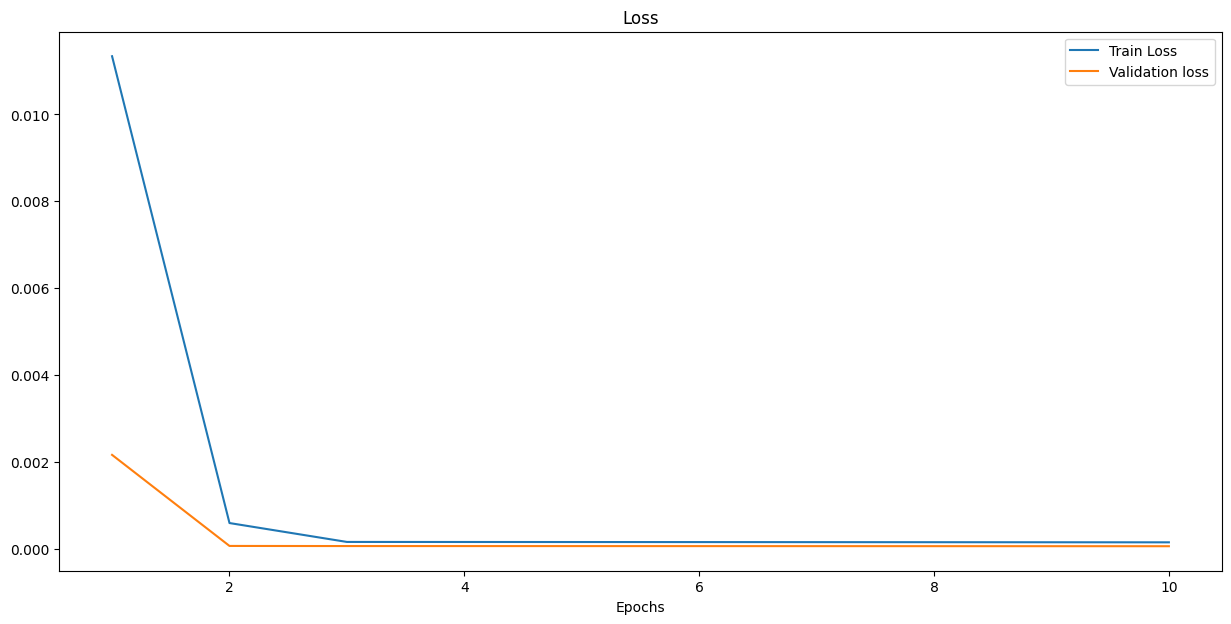

In [44]:
# Plot the loss curves
train_loss = results["Train Loss"]
valid_loss = results["Validation Loss"]
epochs = len(train_loss)

plt.figure(figsize=(15, 7))
plt.plot(range(1, epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, epochs+1), valid_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend();

## Weights seem to have been adjusted by the end of the training phase of the very first epoch, resulting in a low validation error from the start

## It seems that the model has achieved only about a 50% accuracy in predicting if the price will increase on decrease the next day given 10 days of previous changes in price. Lets try plotting the predicted change in price vs the actual for the training, validation and test data sets.

In [45]:
# convert all dates in dataframe into a datetime object for ease of plotting
dates = new_df["Date"].to_list()
dates = np.array(list(map(lambda x: dt.strptime(x, "%m/%d/%Y"), dates)))

## You will notice that the predicted change in price usually has a much lower magnitude than the actual change. This is because the market moves in a somewhat random and unpredictable manner that the LSTM is unable to draw any conclusive pattern based on past 10 days of price changes to confidently predict a huge change in price the following day.

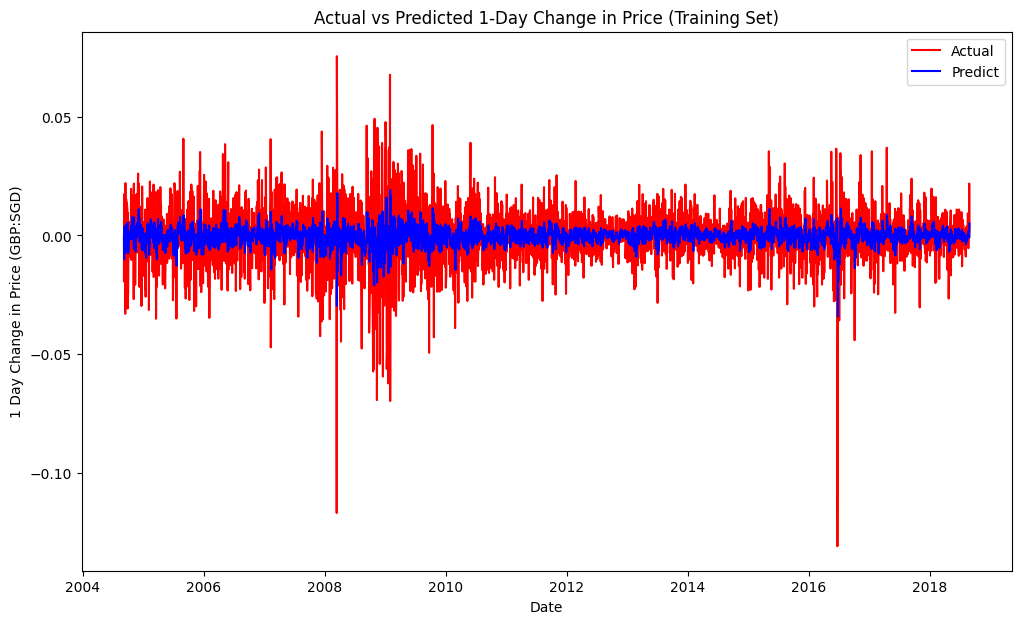

In [46]:
with torch.inference_mode():
  train_predict = model(X_train.to(device)).to('cpu').numpy()

plt.figure(figsize=(12, 7))
X = dates[:len(X_train)]
plt.plot(X, y_train, '-r', label='Actual')
plt.plot(X, train_predict, '-b', label='Predict')
plt.xlabel("Date")
plt.ylabel("1 Day Change in Price (GBP:SGD)")
plt.title("Actual vs Predicted 1-Day Change in Price (Training Set)")
plt.legend()
plt.show();

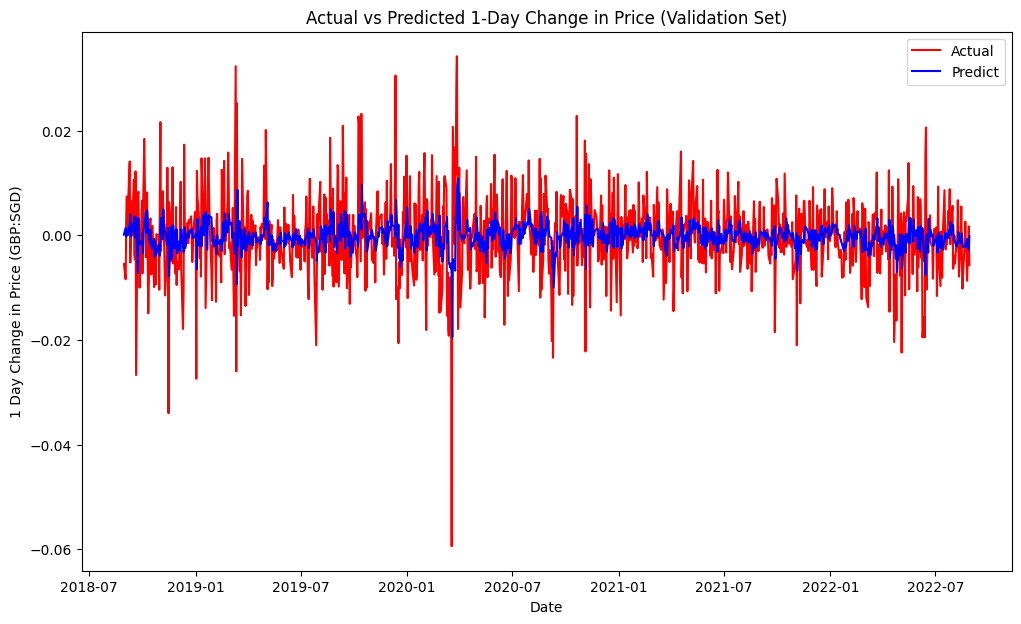

In [47]:
with torch.inference_mode():
  valid_predict = model(X_valid.to(device)).to('cpu').numpy()

plt.figure(figsize=(12, 7))
X = dates[len(X_train):len(X_train)+len(X_valid)]
plt.plot(X, y_valid, '-r', label='Actual')
plt.plot(X, valid_predict, '-b', label='Predict')
plt.xlabel("Date")
plt.ylabel("1 Day Change in Price (GBP:SGD)")
plt.title("Actual vs Predicted 1-Day Change in Price (Validation Set)")
plt.legend()
plt.show();

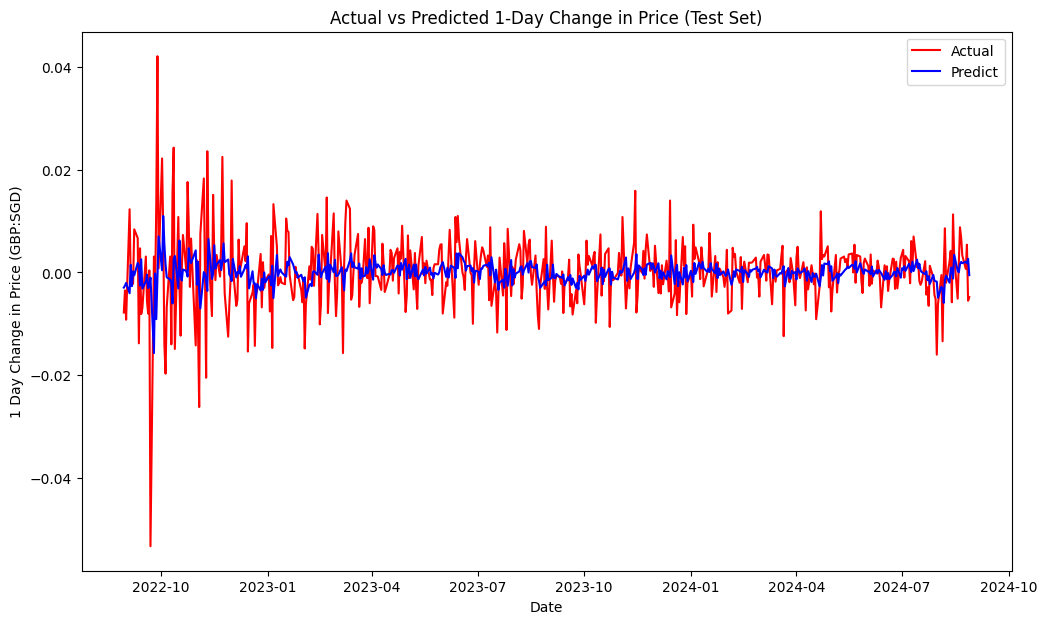

In [48]:
with torch.inference_mode():
  test_predict = model(X_test.to(device)).to('cpu').numpy()

plt.figure(figsize=(12, 7))
X = dates[len(X_train)+len(X_valid):]
plt.plot(X, y_test, '-r', label='Actual')
plt.plot(X, test_predict, '-b', label='Predict')
plt.xlabel("Date")
plt.ylabel("1 Day Change in Price (GBP:SGD)")
plt.title("Actual vs Predicted 1-Day Change in Price (Test Set)")
plt.legend()
plt.show();

In [49]:
def get_accuracy(predictions, actual):
  correct = 0
  incorrect = 0
  for idx, e in enumerate(predictions):
    if e >= 0 and actual[idx] >= 0: # if predicted increase and actually increase in price
      correct += 1
    elif e < 0 and actual[idx] < 0: # if predicted decrease and actually decrease in price
      correct += 1
    else:
      incorrect += 1

  print(f"Correct Predictions: {correct}")
  print(f"Incorrect Predictions: {incorrect}")
  print(f"Accuracy: {(correct/(correct+incorrect))*100:.2f}%")

In [50]:
# Let's try to see how many times the LSTM model correctedly predicted the price will increase/decrease the following day
# for the testing data set
get_accuracy(test_predict, y_test)

Correct Predictions: 270
Incorrect Predictions: 252
Accuracy: 51.72%


Once again only around a 51% accuracy (about the same as randomly guessing whether the price will increase or decrease). Though if we can get around a 55% accuracy consistently across different time periods, that will be very
impressive. This time we shall approximate how much returns we will get if we were to use the model in real-time.

To make things simpler, we will assume that we can buy the currency at the adjusted closing price and we assume that we convert everything from GBP to SGD if the model guesses that the price will decrease (i.e. SGD will appreciate against GBP) and convert everything from SGD to GBP if the model guesses that the price will increase (i.e. GBP will appreciate against SGD). We will start off with 10000 GBP.

In [51]:
# Let's also try calculating returns based on our model
money = [10000, 'G'] # 10000 GBP, 'G' for GBP, 'S' for SGD
for idx, e in enumerate(test_predict):
  if e >= 0: # model guesses that the GBP will appreciate against SGD
    if money[1] == 'S':
      money = [money[0]/new_df.iloc[len(X_train) + len(X_valid) +idx]["Adj Close"], 'G'] # convert from SGD to GBP if any

  else: # model guesses that the GBP will depreciate against SGD
    if money[1] == 'G':
      money = [money[0]*new_df.iloc[len(X_train) + len(X_valid) +idx]["Adj Close"], 'S'] # convert from GBP to SGD if any

# convert back to GBP based on last day data
if money[1] == 'S':
  money = [money[0]/new_df.iloc[-1]["Adj Close"], 'G'] # convert from SGD to GBP if any

print(f"Returns: GBP {money[0] - 10000:.2f}")

Returns: GBP 78.88


## Now lets consider using the 2 technical indicators we had established earlier. They were the difference to 200-day moving average and RSI to try predicting the T+1 change in price. We will try to perform linear regressions on the following (though I do not have high hopes here):
1. Difference to 200-day MA only
2. RSI only
3. Both indicators together
4. Both indicators and the output from the LSTM model

In [52]:
# First experiment (Difference to MA only)
new_X_train = new_df[["Difference to MA"]][:len(X_train)].to_numpy()
new_X_test = new_df[["Difference to MA"]][len(X_train)+len(X_valid):].to_numpy()
reg = linear_model.LinearRegression()
reg.fit(new_X_train, y_train)
test_preds = reg.predict(new_X_test)

# Accuracy
get_accuracy(test_preds, y_test)

Correct Predictions: 254
Incorrect Predictions: 268
Accuracy: 48.66%


In [53]:
# Second experiment (RSI only)
new_X_train = new_df[["RSI"]][:len(X_train)].to_numpy()
new_X_test = new_df[["RSI"]][len(X_train)+len(X_valid):].to_numpy()
reg = linear_model.LinearRegression()
reg.fit(new_X_train, y_train)
test_preds = reg.predict(new_X_test)

# Accuracy
get_accuracy(test_preds, y_test)

Correct Predictions: 256
Incorrect Predictions: 266
Accuracy: 49.04%


In [54]:
# Third experiment (both indicators)
new_X_train = new_df[["Difference to MA", "RSI"]][:len(X_train)].to_numpy()
new_X_test = new_df[["Difference to MA", "RSI"]][len(X_train)+len(X_valid):].to_numpy()
reg = linear_model.LinearRegression()
reg.fit(new_X_train, y_train)
test_preds = reg.predict(new_X_test)

# Accuracy
get_accuracy(test_preds, y_test)

Correct Predictions: 254
Incorrect Predictions: 268
Accuracy: 48.66%


In [55]:
# Last experiment (both indicators and LSTM output)
with torch.inference_mode():
  train_lstm_res = model(X_train.to(device)).cpu().numpy()
  test_lstm_res = model(X_test.to(device)).cpu().numpy()

new_X_train = new_df[["Difference to MA", "RSI"]][:len(X_train)].to_numpy()
new_X_train = np.concatenate((new_X_train, train_lstm_res), axis = 1)
new_X_test = new_df[["Difference to MA", "RSI"]][len(X_train)+len(X_valid):].to_numpy()
new_X_test = np.concatenate((new_X_test, test_lstm_res), axis = 1)

reg = linear_model.LinearRegression()
reg.fit(new_X_train, y_train)
test_preds = reg.predict(new_X_test)

# Accuracy
get_accuracy(test_preds, y_test)

Correct Predictions: 257
Incorrect Predictions: 265
Accuracy: 49.23%


# Conclusion:

Using a LSTM model yielded was able to predict the direction at which the price would change the next day at about a 50% accuracy. Performing a linear regression on the difference to the 200-day Simple Moving Average and the RSI indicators yielded subpar results of below 50% which were lower than using the LSTM model, which I am honestly not disappointed about, given how difficult it is to make sense of the abundance of "noise" and randomness of the market.

There are many improvements that could be made:
1. The hyperparameters of the LSTM (such as learning rate, number of epochs, batch size, number of stacked LSTMs etc.) could all be varied to find the optimal combination. I tried experimenting around with them for a while but I could have found better sets of hyperparameters.
2. Perhaps I should also have done a forward filling / fill based on surrounding mean for the non-trading days (such as the weekends) to get a continuous time series of 1 day separation.
3. Ideally, I can consider the high/low prices and perhaps assume that we buy at the mean of high and low, rather than buying at the adjusted closing price.
4. I can consider looking at more past days as well.

Future Work:
1. Rather than looking at RSI and MA indicators, perhaps I can try out other notable indicators such as [MACD](https://www.investopedia.com/terms/m/macd.asp) (Moving Average Covergence Divergence) or [Bollinger Band](https://www.investopedia.com/terms/b/bollingerbands.asp).
2. Try predicting further into the future and try to take the volume/low/high data into consideration as well. (especially if we want longer-term predictions)
3. I can also consider looking at pair trading, which could give better signals than the other indicators.
4. Lastly, I can also try a different model architecture like a transformer model or simply a binary classification if we only need to direction at which the price will move (up or down).